### References:
https://keras.io/activations/
add layers in keras

http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/
downlaod stock data

http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction
transform stock price to train/test set
predict value at t+1


In [230]:
import pandas as pd
import numpy as np
from pandas_datareader import data
from tensorflow.python.keras.layers import LSTM, Embedding,Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.models import Sequential
from numpy import newaxis
import matplotlib.pyplot as plt

In [482]:
#Retrive APPLE stock price\n
tickers = 'AAPL'
data_source = 'iex'
start_date = '2013-01-01'
end_date = '2018-03-31'
panel_data = data.DataReader(tickers, data_source, start_date, end_date)
panel_data =panel_data.reset_index()

train_index=panel_data[panel_data['date']=='2017-12-29'].index[0]
aapl=panel_data['close'].tolist()
stock=panel_data.loc[:, panel_data.columns != 'date'].as_matrix()
two_features=panel_data.loc[:, ['close','volume']].as_matrix()

5y


In [418]:
# Converting price to log return
def log_return(price):
    log_return=[]
    price=np.log(price)
    for i in range(len(price)-1):
        log_return.append(price[i+1]-price[i])
    price=log_return
    return price

In [483]:
log_re=np.array(log_return(aapl))

In [520]:
# Normalizing data
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        # In the case of log return being 0, all sequence will be assigned 0
        if window[0].all()==0:
            normalised_window = [0 for p in window]
        else:
            normalised_window = [p / (window[0])- 1 for p in window]
        normalised_data.append(np.array(normalised_window))
    return normalised_data

In [220]:
#Denormalize Data
def get_price(y_val,train_index,stock):
    final=[]
    for i,val in enumerate(y_val):
        final.append((val+1)*stock[train_index-30+i])
    return final

In [497]:
def predict_point_by_point(model, data):
    #Predict future value by taking in all true data
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [250]:
# Load data with multiple features
def load_price_m(price_data,seq_len,split):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(price_data) - sequence_length):
        result.append(price_data[index: index + sequence_length,:])
    result = normalise_windows(result)
    row = split-seq_len
    
    train = result[:int(row)]
    test=result[int(row):]
    np.random.shuffle(train)
    x_train = list(map(lambda x: x[:-1, :],train))
    y_train = list(map(lambda x: x[-1, -2],train))
    x_test = list(map(lambda x: x[:-1, :],test))
    y_test = list(map(lambda x: x[-1, -2],test))
    print(len(y_test))
    x_train = np.array(x_train)
    y_train=np.array(y_train)
    x_test=np.array(x_test)
    y_test=np.array(y_test)
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return [x_train, y_train, x_test, y_test]

In [504]:
# Load data when there is only one feature
def load_price(price, seq_len,split,log):
    if log==True:
        log_return=[]
        price=np.log(price)
        for i in range(len(price)-1):
            log_return.append((price[i+1]-price[i]))
        price=log_return
        row = split-seq_len-1
        #price=(price-np.mean(price,axis=0))/np.std(price,axis=0)
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(price) - sequence_length):
        result.append(price[index: index + sequence_length])
    if log != True:
        result = normalise_windows(result)
        row = split-seq_len
    
    result = np.array(result)
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]
    print('number of test cases: ',len(y_test))

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return [x_train, y_train, x_test, y_test]

In [289]:
# calculate the cumulative return of a strategy
def total_return(real,predicted,log=False):
    if log==False:
        position=[x - y for x, y in zip(predicted,real)]
        position=list(map(lambda x: -1 if x<0 else 1,position))
    else:
        position=list(map(lambda x: -1 if x<0 else 1,predicted))
    
    diff=[]
    for i,item in enumerate(real):
        if i !=0:
            diff.append(item-real[i-1])
    return_predict=[x * y for x, y in zip(position, diff)]
    cum_return=[]
    for i in range(len(return_predict)):
        cum_return.append(sum(return_predict[:i+1]))
    return cum_return

### Single feature

In [505]:
#one feature
seq_len=30
x_train, y_train, x_val, y_val = load_price(aapl,seq_len,train_index,False)

number of test cases:  61


In [506]:
model = Sequential()
model.add(LSTM(30,input_shape=(seq_len, 1),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation('tanh'))

model.add(Dense(16))
model.add(Activation('tanh'))

model.add(Dense(1))
model.add(Activation('tanh'))
model.compile(loss="mse", optimizer="rmsprop")

model.fit(
    x_train,
    y_train,
    batch_size=10,
    epochs=3,
    validation_split=0.1)

Train on 1042 samples, validate on 116 samples
Epoch 1/3
1042/1042 [==============================]1042/1042 [==============================] - 16s 16ms/step - loss: 0.0014 - val_loss: 0.0010

In [507]:
predicted = predict_point_by_point(model, x_val)

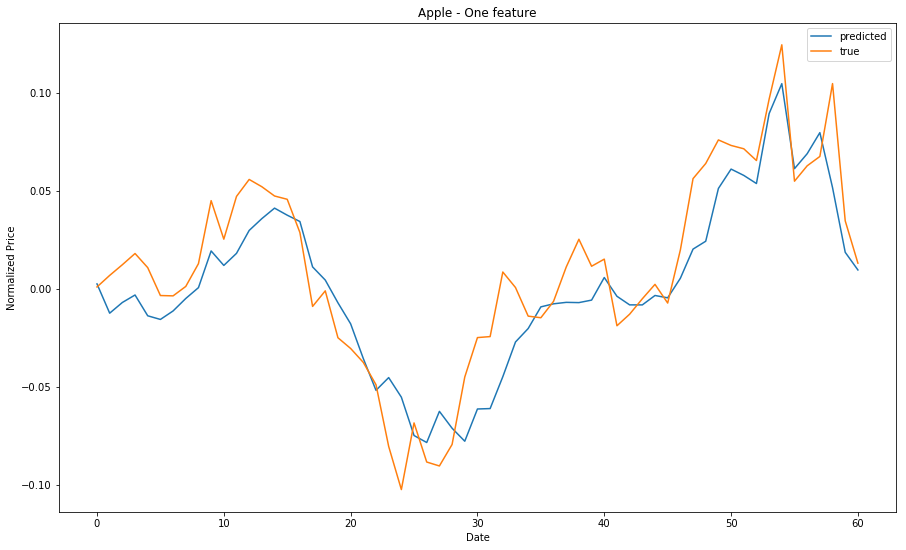

In [510]:
fig, ax1 = plt.subplots(figsize=(15,9))
#ax2 = ax1.twinx()
ax1.plot(predicted,label='predicted')
ax1.plot(y_val,label='true')
#ax2.plot(total_return(aapl[train_index-1:-2],predicted,log=False),'g--',label='cumulative return')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Price')
#ax2.set_ylabel('Return')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.title('Apple - One feature')
plt.show()

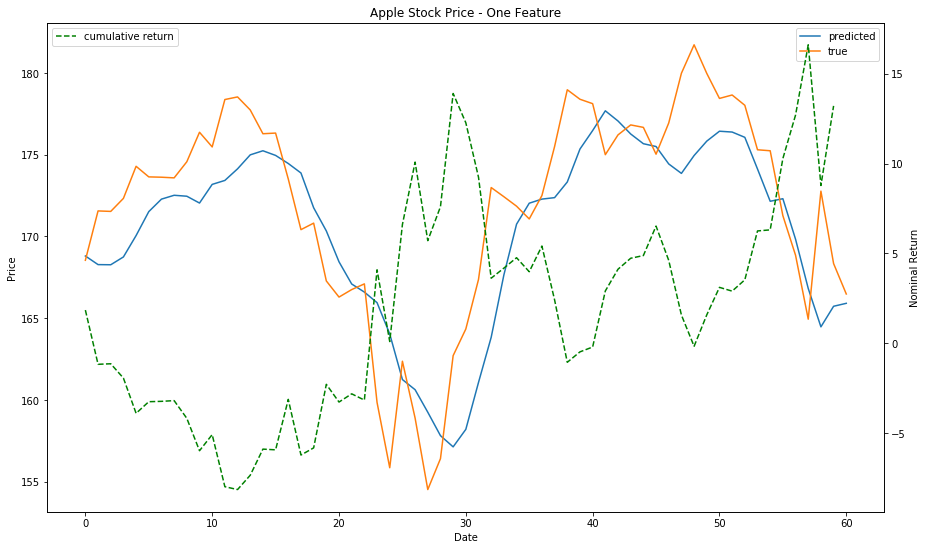

In [512]:
fig, ax1 = plt.subplots(figsize=(15,9))
ax2 = ax1.twinx()
ax1.plot(get_price(predicted,train_index,aapl),label='predicted')
ax1.plot(aapl[train_index:-1],label='true')
ax2.plot(total_return(aapl[train_index-1:-2],get_price(predicted,train_index,aapl)),'g--',label='cumulative return')

ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_ylabel('Nominal Return')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.title("Apple Stock Price - One Feature")
plt.show()

# Two Features -close, volume

In [521]:
#multiple features
seq_len=30
x_train, y_train, x_val, y_val=load_price_m(two_features,seq_len,train_index)

61


In [522]:
model = Sequential()
model.add(LSTM(30,input_shape=(seq_len, 2),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation('tanh'))

model.add(Dense(16))
model.add(Activation('tanh'))

model.add(Dense(1))
model.add(Activation('tanh'))
model.compile(loss="mse", optimizer="rmsprop")

model.fit(
    x_train,
    y_train,
    batch_size=10,
    epochs=3,
    validation_split=0.1)

Train on 1042 samples, validate on 116 samples
Epoch 1/3
1042/1042 [==============================]1042/1042 [==============================] - 17s 16ms/step - loss: 0.0026 - val_loss: 8.4239e-04

In [523]:
predicted = predict_point_by_point(model, x_val)

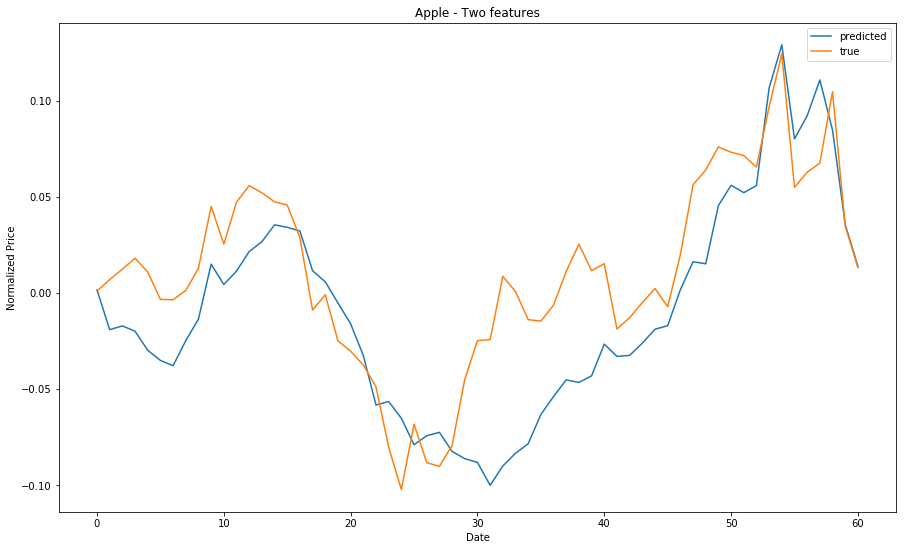

In [525]:
fig, ax1 = plt.subplots(figsize=(15,9))
#ax2 = ax1.twinx()
ax1.plot(predicted,label='predicted')
ax1.plot(y_val,label='true')
#ax2.plot(total_return(aapl[train_index-1:-2],predicted,log=False),'g--',label='cumulative return')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Price')
#ax2.set_ylabel('Return')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.title('Apple - Two features')
plt.show()

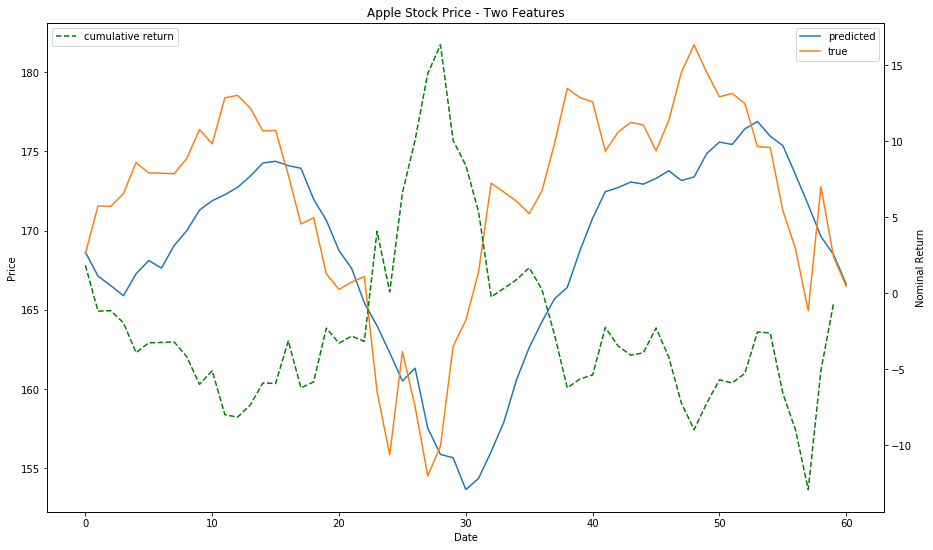

In [526]:
fig, ax1 = plt.subplots(figsize=(15,9))
ax2 = ax1.twinx()
ax1.plot(get_price(predicted,train_index,aapl),label='predicted')
ax1.plot(aapl[train_index:-1],label='true')
ax2.plot(total_return(aapl[train_index-1:-2],get_price(predicted,train_index,aapl)),'g--',label='cumulative return')

ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_ylabel('Nominal Return')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.title("Apple Stock Price - Two Features")
plt.show()

# All features

In [527]:
#multiple features
seq_len=30
x_train, y_train, x_val, y_val=load_price_m(stock,seq_len,train_index)

61


In [529]:
model = Sequential()
model.add(LSTM(30,input_shape=(seq_len, 5),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation('tanh'))

model.add(Dense(16))
model.add(Activation('tanh'))

model.add(Dense(1))
model.add(Activation('tanh'))
model.compile(loss="mse", optimizer="rmsprop")

model.fit(
    x_train,
    y_train,
    batch_size=10,
    epochs=3,
    validation_split=0.1)

Train on 1042 samples, validate on 116 samples
Epoch 1/3
1042/1042 [==============================]1042/1042 [==============================] - 19s 18ms/step - loss: 0.0022 - val_loss: 0.0047

In [530]:
predicted = predict_point_by_point(model, x_val)

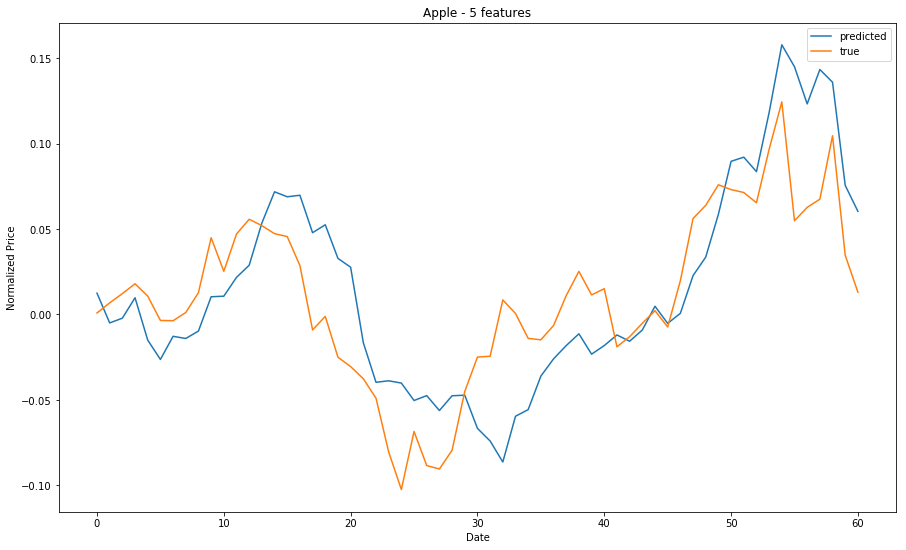

In [531]:
fig, ax1 = plt.subplots(figsize=(15,9))
#ax2 = ax1.twinx()
ax1.plot(predicted,label='predicted')
ax1.plot(y_val,label='true')
#ax2.plot(total_return(aapl[train_index-1:-2],predicted,log=False),'g--',label='cumulative return')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Price')
#ax2.set_ylabel('Return')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.title('Apple - 5 features')
plt.show()

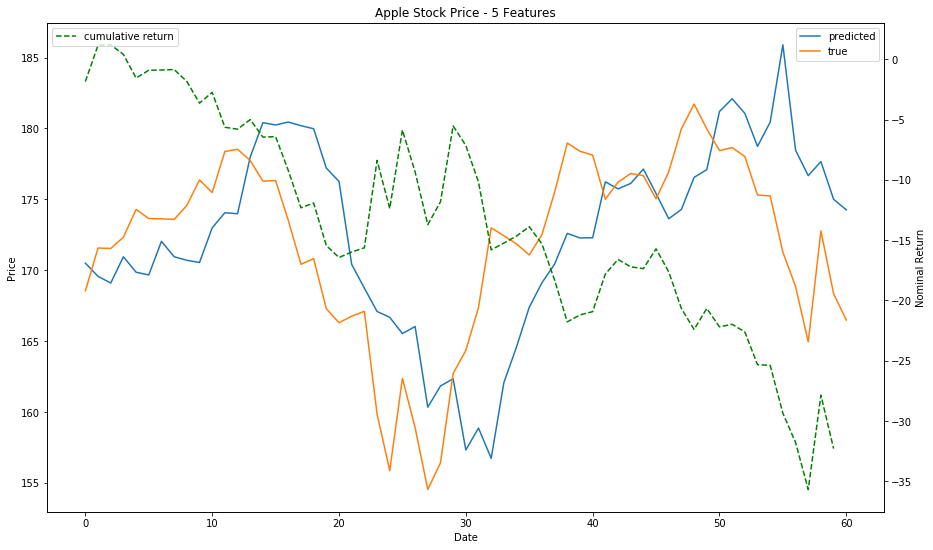

In [532]:
fig, ax1 = plt.subplots(figsize=(15,9))
ax2 = ax1.twinx()
ax1.plot(get_price(predicted,train_index,aapl),label='predicted')
ax1.plot(aapl[train_index:-1],label='true')
ax2.plot(total_return(aapl[train_index-1:-2],get_price(predicted,train_index,aapl)),'g--',label='cumulative return')

ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_ylabel('Nominal Return')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.title("Apple Stock Price - 5 Features")
plt.show()

# Predicting Log return

In [289]:
# Log return: calculate the cumulative return of a strategy
def total_return_log(real,predicted,log=False):
    if log==False:
        position=[x - y for x, y in zip(predicted,real)]
        position=list(map(lambda x: -1 if x<0 else 1,position))
    else:
        position=list(map(lambda x: -1 if x<0 else 1,predicted))
    
    diff=[]
    for i,item in enumerate(real):
        if i !=0:
            diff.append(item-real[i-1])
    return_predict=[x * y for x, y in zip(position, diff)]
    cum_return=[]
    for i in range(len(return_predict)):
        cum_return.append(sum(return_predict[:i+1]))
    return cum_return

In [549]:
def accuracy(predicted,real):
    acc=0
    for i, item in enumerate(predicted):
        if item*real[i]>0:
            acc+=1
        else:
            pass
    return acc/len(real)

In [534]:
# converting price to log return
log_re=np.array(log_return(aapl))

In [535]:
seq_len=30
x_train, y_train, x_val, y_val = load_price(log_re,seq_len,train_index,False)

number of test cases:  60


In [542]:
model = Sequential()
model.add(LSTM(30,input_shape=(seq_len, 1),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation('tanh'))

model.add(Dense(16))
model.add(Activation('tanh'))

model.add(Dense(1))
model.add(Activation('tanh'))
model.compile(loss="mse", optimizer="rmsprop")

model.fit(
    x_train,
    y_train,
    batch_size=10,
    epochs=3,
    validation_split=0.1)

Train on 1042 samples, validate on 116 samples
Epoch 1/3
1042/1042 [==============================]1042/1042 [==============================] - 20s 19ms/step - loss: 161.8454 - val_loss: 81.1474

In [543]:
predicted = predict_point_by_point(model, x_val)

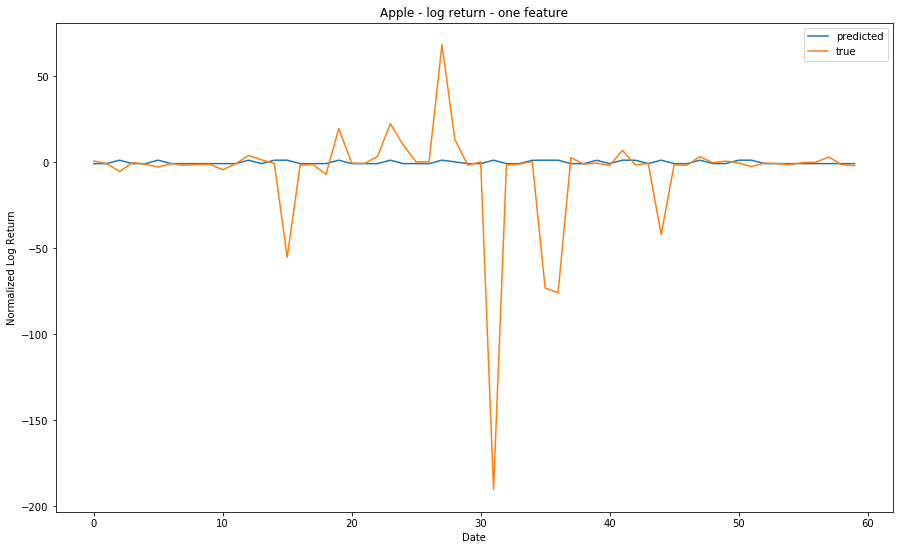

In [545]:
fig, ax1 = plt.subplots(figsize=(15,9))
#ax2 = ax1.twinx()
ax1.plot(predicted,label='predicted')
ax1.plot(y_val,label='true')
#ax2.plot(total_return(aapl[train_index-1:-2],predicted,log=False),'g--',label='cumulative return')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Log Return')
#ax2.set_ylabel('Return')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.title('Apple - log return - one feature')
plt.show()

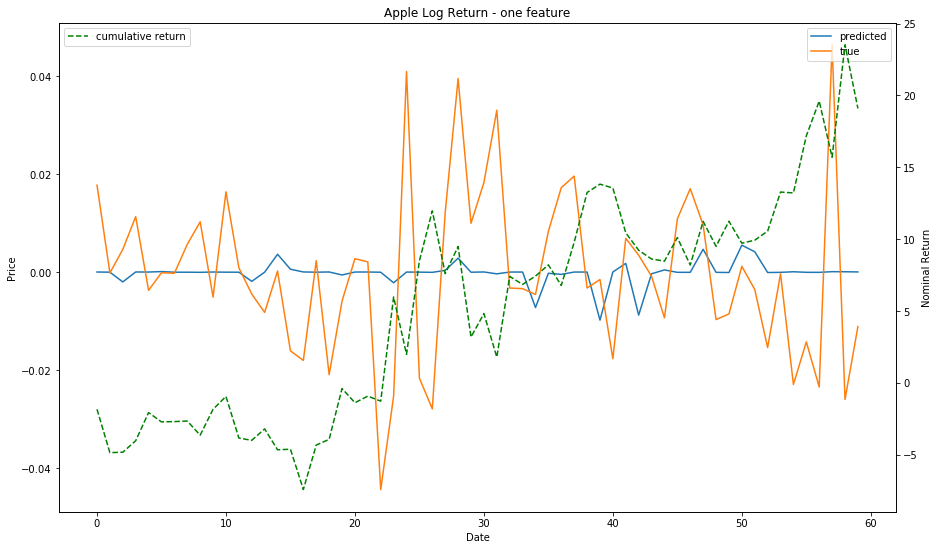

In [552]:
fig, ax1 = plt.subplots(figsize=(15,9))
ax2 = ax1.twinx()
ax1.plot(get_price(predicted,train_index,log_re),label='predicted')
ax1.plot(log_re[train_index:-1],label='true')
# When log ==True, the position is the sign of the predicted log return
ax2.plot(total_return(aapl[train_index-1:-2],get_price(predicted,train_index,log_re),log=True),'g--',label='cumulative return')

ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_ylabel('Nominal Return')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.title("Apple Log Return - one feature")
plt.show()

In [553]:
accuracy(predicted,y_val)

0.6333333333333333